In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading the Data

In [4]:
paps = spark.read.json("../data/processed/dummy.json/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())

## Clustering

In [6]:
cols = papersWIDs.columns
cols.remove("title")
cols.remove("id")
cols

['CERN_LHC_Coll',
 'GeV',
 'None',
 'anomaly',
 'background',
 'dark_matter',
 'dark_matter__mass',
 'effective_field_theory',
 'heavy_ion__scattering',
 'higher-order__1',
 'kinematics',
 'lattice',
 'lattice_field_theory',
 'new_physics',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics',
 'quark',
 'sensitivity',
 'stability',
 'structure']

In [7]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler

In [8]:
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())

3000
2931


In [9]:
assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
transformed_data = assembler.transform(papersWIDs_woNA)

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [11]:
scale_model  = scaler.fit(transformed_data)
scaled_data = scale_model.transform(transformed_data)

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
metric_name = 'silhouette'
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName=metric_name, distanceMeasure='squaredEuclidean')
scores = dict()
for i in range(2, 50):
    kmeans_algo = KMeans(featuresCol="scaledFeatures", k=i)
    kmeans_fit = kmeans_algo.fit(scaled_data)
    kmeans_out = kmeans_fit.transform(scaled_data)
    score = evaluator.evaluate(kmeans_out)
    print(i, " ", score)
    scores[i] = score

2   0.4644613596284413
3   0.4311748376399027
4   0.43439895477362817
5   0.4001464719439111
6   0.4353801601340351
7   0.35142012418801943
8   0.343092981768614
9   0.341607115929847
10   0.385573521838854
11   0.3730505600722615
12   0.3727522645189519
13   0.38437618653703376
14   0.4301594497511217
15   0.4593111266763469
16   0.44425288190598955
17   0.4442616706437847
18   0.5009161146192433
19   0.4799797921619405
20   0.546384786506104
21   0.5219033456423906
22   0.5023922484502105
23   0.5353024512769597
24   0.5492445253200906
25   0.549550580098358
26   0.6002932397586577
27   0.5597177480621686
28   0.6113166669128491
29   0.6118783293102958
30   0.610091690196453
31   0.6235374371317313
32   0.6093844596224901
33   0.6039111405197585
34   0.6105479252264168
35   0.5959942423468542
36   0.615659094220823
37   0.6522209806358737
38   0.6500449933807424
39   0.4710512494230129
40   0.45499289213856803
41   0.650097323991757
42   0.6314048316614166
43   0.6521580448045281
44 

In [13]:
import matplotlib.pyplot as plt

In [18]:
import numpy as np

In [20]:
scores_array = np.array([[k, scores[k]] for k in scores.keys()])

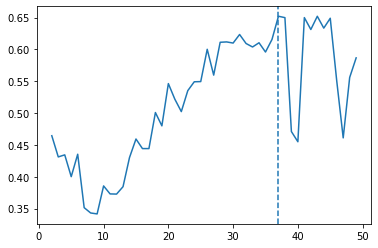

In [26]:
plt.plot(scores_array[:,0], scores_array[:,1])
plt.axvline(x=37, linestyle = '--')

In [29]:
kmeans_algo = KMeans(featuresCol="scaledFeatures", k=37)
kmeans_fit = kmeans_algo.fit(scaled_data)
kmeans_out = kmeans_fit.transform(scaled_data)

                     

In [31]:
kmeans_out.select("id", "prediction")

id,prediction
0,33
1,4
2,1
3,29
4,0
5,20
6,33
7,29
8,1
9,1


In [33]:
kmeans_out.groupby("prediction").count().sort(desc("count"))

prediction,count
29,1065
7,124
12,104
28,97
16,92
11,91
10,91
32,86
0,84
9,83


In [38]:
kmeans_out.filter("new_physics == 1").count()

275

In [40]:
kmeans_out.filter("new_physics == 1").groupby("prediction").count().sort(desc("count"))

prediction,count
7,124
6,44
1,13
22,11
4,11
32,10
0,8
10,7
26,7
3,5


In [36]:
kmeans_out.filter("prediction == 29").select("title").collect()

[Row(title='Hints of dark matter-neutrino interactions in Lyman-$\\alpha$ data'),
 Row(title='A Brief Look at the Chirality-Flow Formalism for Standard Model Amplitudes'),
 Row(title='Mirror Twin Higgs Cosmology: Constraints and a Possible Resolution to the $H_0$ and $S_8$ Tensions'),
 Row(title='Impact of charged and neutral Drell-Yan Asymmetries on precision measurements'),
 Row(title='Future Constraints on Primordial Black Holes from XGIS-THESEUS'),
 Row(title='Probing light dark matter particles with astrophysical experiments'),
 Row(title='Shining ALP Dark Radiation'),
 Row(title='Lepton flavor violation in the Littlest Higgs Model with T parity realizing an inverse seesaw'),
 Row(title='Search for the decay $B^{0}\\rightarrow K^{\\ast 0}\\tau^{+}\\tau^{-}$ at the Belle experiment'),
 Row(title='A semi-numerical method for one-scale problems applied to the $\\overline{MS}$-on-shell relation'),
 Row(title='Beauty 2020 Workshop Summary'),
 Row(title="Generalization of Weinberg's Com